# Trabalho Prático 2 - CCF 726
**Aluno**: Fábio Trindade Ramos - **Matrícula**: 3869
## Objetivo
O objetivo deste trabalho é aplicar técnicas de engenharia de atributos e ajustar os parâmetros do algoritmo adotado para melhorar os resultados de classificação do problema de previsão de [churn](https://www.kaggle.com/datasets/undersc0re/predict-the-churn-risk-rate).

## Configuração inicial

In [1]:
import pathlib
import sys
import os
import warnings
requirements_filename = 'requirements_tp2.txt'
if str(pathlib.Path().resolve().name) == "notebooks":
    root = str(pathlib.Path().resolve().parent.parent)+os.sep
    sys.path.append(root)
    requirements_path = root + 'requirements/'+requirements_filename
else:
    ! git clone --branch ap8 https://github.com/Fabio-Trindade/Eng-Aprendizado-Maquina.git
    root = str(pathlib.Path().resolve())
    src_path = root + '/Eng-Aprendizado-Maquina/'
    requirements_path = src_path + 'requirements/'+requirements_filename
    sys.path.append(root + '/Eng-Aprendizado-Maquina/')
warnings.filterwarnings("ignore")

### Instalação do TPOT

In [2]:
! pip install tpot

## Definindo raíz do projeto e caminho do dataset

In [3]:
from src.constants.KPaths import KPaths

root = KPaths.path_root
path_to_dataset = root + '/datasets/churn.csv'

## Análise Exploratória

### Leitura do *dataset*

In [4]:
import pandas as pd
df = pd.read_csv(path_to_dataset)
df

,Unnamed: 0,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,0,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.630000,53005.25,17.0,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,1,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,...,306.340000,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,2,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,...,516.160000,21027.00,22.0,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,3,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,...,53.270000,25239.56,6.0,567.660000,No,Yes,Yes,Unsolved,Poor Website,1
4,4,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,...,113.130000,24483.66,16.0,663.060000,No,Yes,Yes,Solved,Poor Website,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,36987,46,F,6F51HFO,NaN,Basic Membership,2017-09-21,No,xxxxxxxx,Credit/Debit Card Offers,...,-650.682759,27277.68,6.0,639.510000,No,Yes,Yes,No Information Available,No reason specified,1
36988,36988,29,F,21KSM8Y,Town,Basic Membership,2016-06-27,No,xxxxxxxx,Without Offers,...,-638.123421,11069.71,28.0,527.990000,Yes,No,No,Not Applicable,Poor Customer Service,1
36989,36989,23,F,XK1IM9H,NaN,Basic Membership,2016-09-11,Yes,CID3838,Gift Vouchers/Coupons,...,154.940000,38127.56,Error,680.470000,No,Yes,Yes,Unsolved,Poor Website,1
36990,36990,53,M,K6VTP1Z,Village,Platinum Membership,2017-06-15,No,xxxxxxxx,Gift Vouchers/Coupons,...,482.610000,2378.86,20.0,197.264414,Yes,Yes,No,Not Applicable,No reason specified,0


### Visão geral do dataset

#### Dados nulos e tipos dos dados

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    36992 non-null  int64  
 1   age                           36992 non-null  int64  
 2   gender                        36992 non-null  object 
 3   security_no                   36992 non-null  object 
 4   region_category               31564 non-null  object 
 5   membership_category           36992 non-null  object 
 6   joining_date                  36992 non-null  object 
 7   joined_through_referral       36992 non-null  object 
 8   referral_id                   36992 non-null  object 
 9   preferred_offer_types         36704 non-null  object 
 10  medium_of_operation           36992 non-null  object 
 11  internet_option               36992 non-null  object 
 12  last_visit_time               36992 non-null  object 
 13  d

O *dataset* contém 36.992 observações com 24 atributos cada. Três destes atributos são números reais, 4 são números inteiros, e 17 são strings. Além disso, as colunas *region_category*, *preferred_offer_types* e *points_in_wallet* contém dados nulos.

### Descrição estatística dos dados numéricos

In [6]:
numeric_columns = ['age','days_since_last_login','avg_time_spent','avg_transaction_value','points_in_wallet','churn_risk_score']
df[numeric_columns].describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,0.540982
std,15.867412,228.819900,398.289149,19444.806226,194.063624,0.498324
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,0.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,0.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,1.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,1.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,1.000000


Através das estatísticas acima percebe-se que:

* As colunas numéricas possuem altos valores de desvio padrão, ou seja, estão dispersos em relação a média.
* As colunas *days_since_last_login* e *avg_time_spent* possuem valores negativos, os quais não deveriam existir para estas colunas, uma vez que representam, respectivamente, os dias passados desde o último *login* e a média de tempo gasto. Talvez, para a coluna *days_since_last_login*, valores negativos indiquem que o usuário não acessa o aplicativo há muito tempo.
* Os valores numéricos possuem diferentes escalas.
* Nestes dados podem ser aplicados técnicas de normalização.

#### Histograma dos dados numéricos

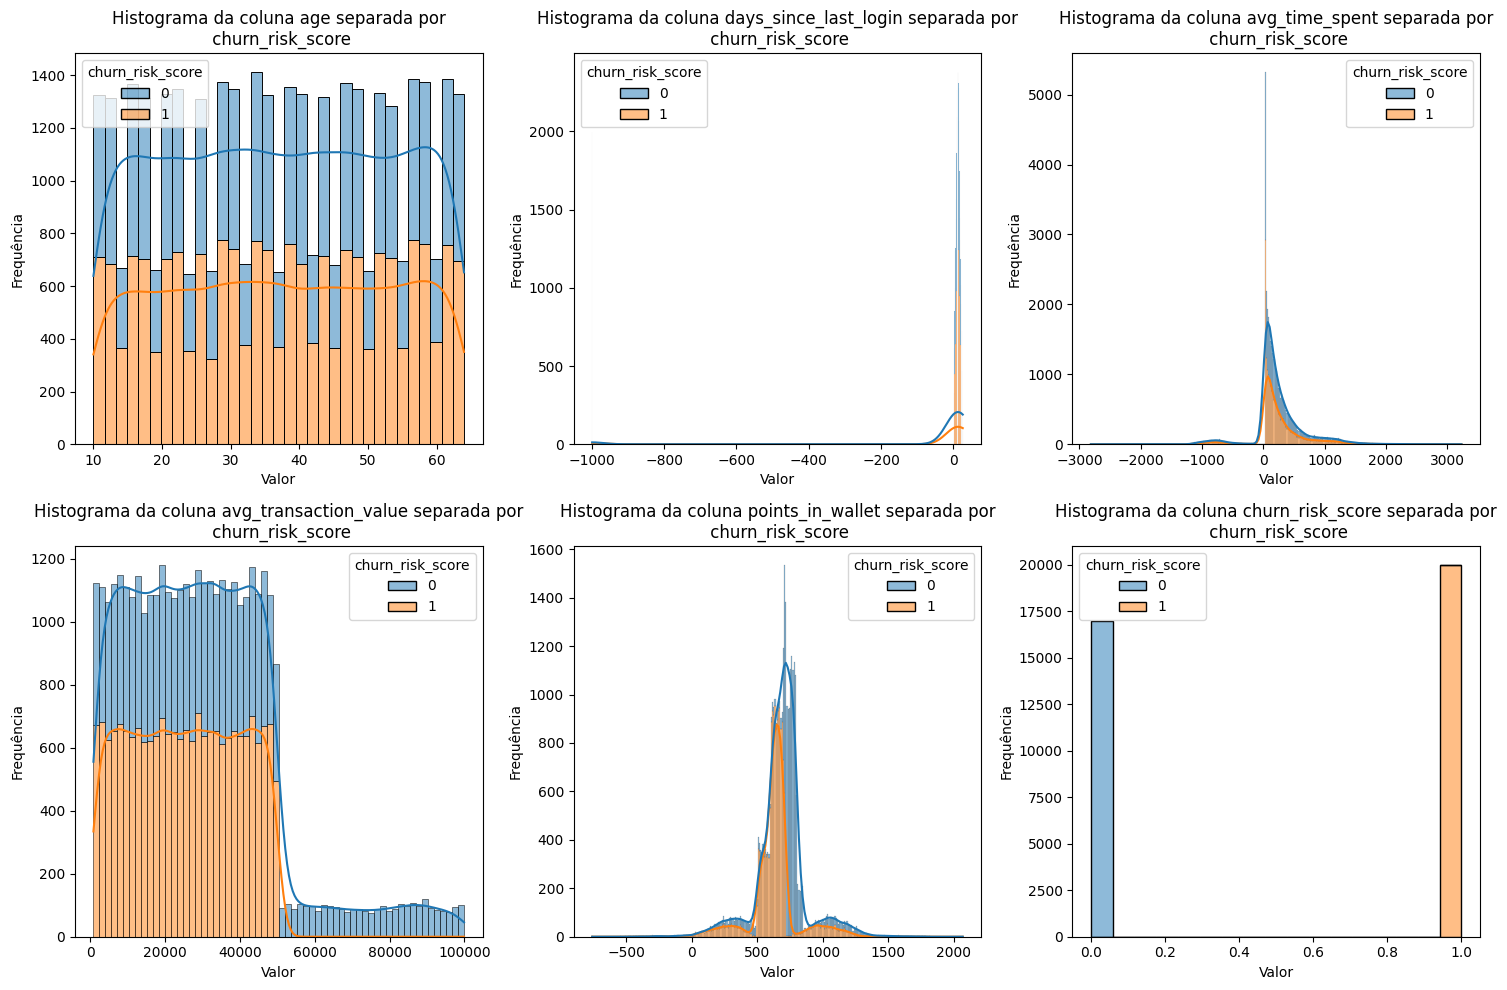

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(data=df, x=df[col], kde=True, hue='churn_risk_score', multiple='stack', ax=axes[i])

    axes[i].set_title(f'Histograma da coluna {col} separada por\n churn_risk_score')
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Frequência')

plt.tight_layout()

plt.show()

As seguintes observações podem ser realizadas a partir dos histogramas acima:

* A quantidade de *churns* e não *churns* não possuem um desbalanceamento relevante, visto no histograma de *churn_risk_score*.

* Poucos valores de transação média estão acima de 50.000, sendo a maioria entre 0 e 50.000 (*avg_transaction_value*). Além disso, quase todas as pessoas que possuem valores de transação acima de 50.000 não possuem risco de deixar o banco.

* Os valores em *days_since_last_login* aparentemente possuem alguma anomalia devido aos valores negativos.

* A idade dos usuários do aplicativo está relativamente balanceada.

* A maioria dos usuários possuem entre 500 e 1000 pontos em sua carteira, sendo que usuários que possuem entre 700 e 800 pontos apresentam risco baixo de deixar o banco.

#### Análise par a par dos atributos numéricos

##### Correlação

<Axes: >

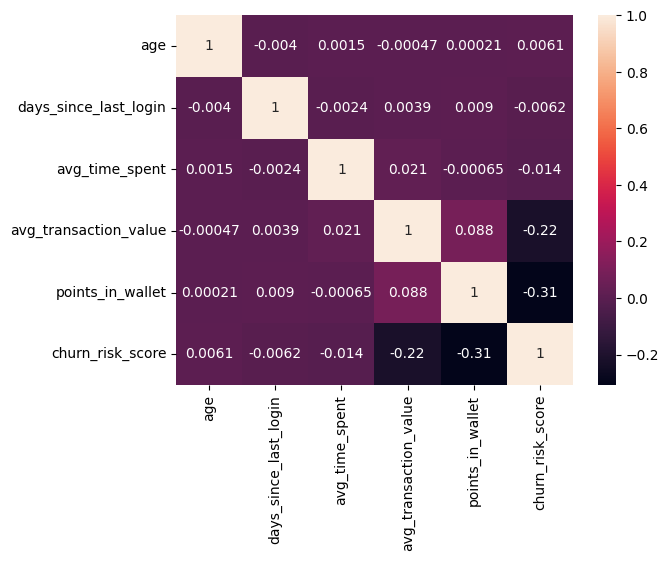

In [8]:
import seaborn as sns
sns.heatmap(data=df[numeric_columns].corr(), annot=True)

As únicas colunas que possuem uma possível correlação são *points_in_wallet* e *avg_transaction_value* com a coluna *churn_risk_score*, sendo esta uma correlação fraca e negativa, ou seja, quanto maior o valor em *points_in_wallet* e *avg_transaction_value* menor é a chance do usuário deixar do banco, e vice-versa. É possível ver esta leve tendência tanto nos histogramas acima quanto nos gráficos de dispersão abaixo.

##### Gráficos de dispersão

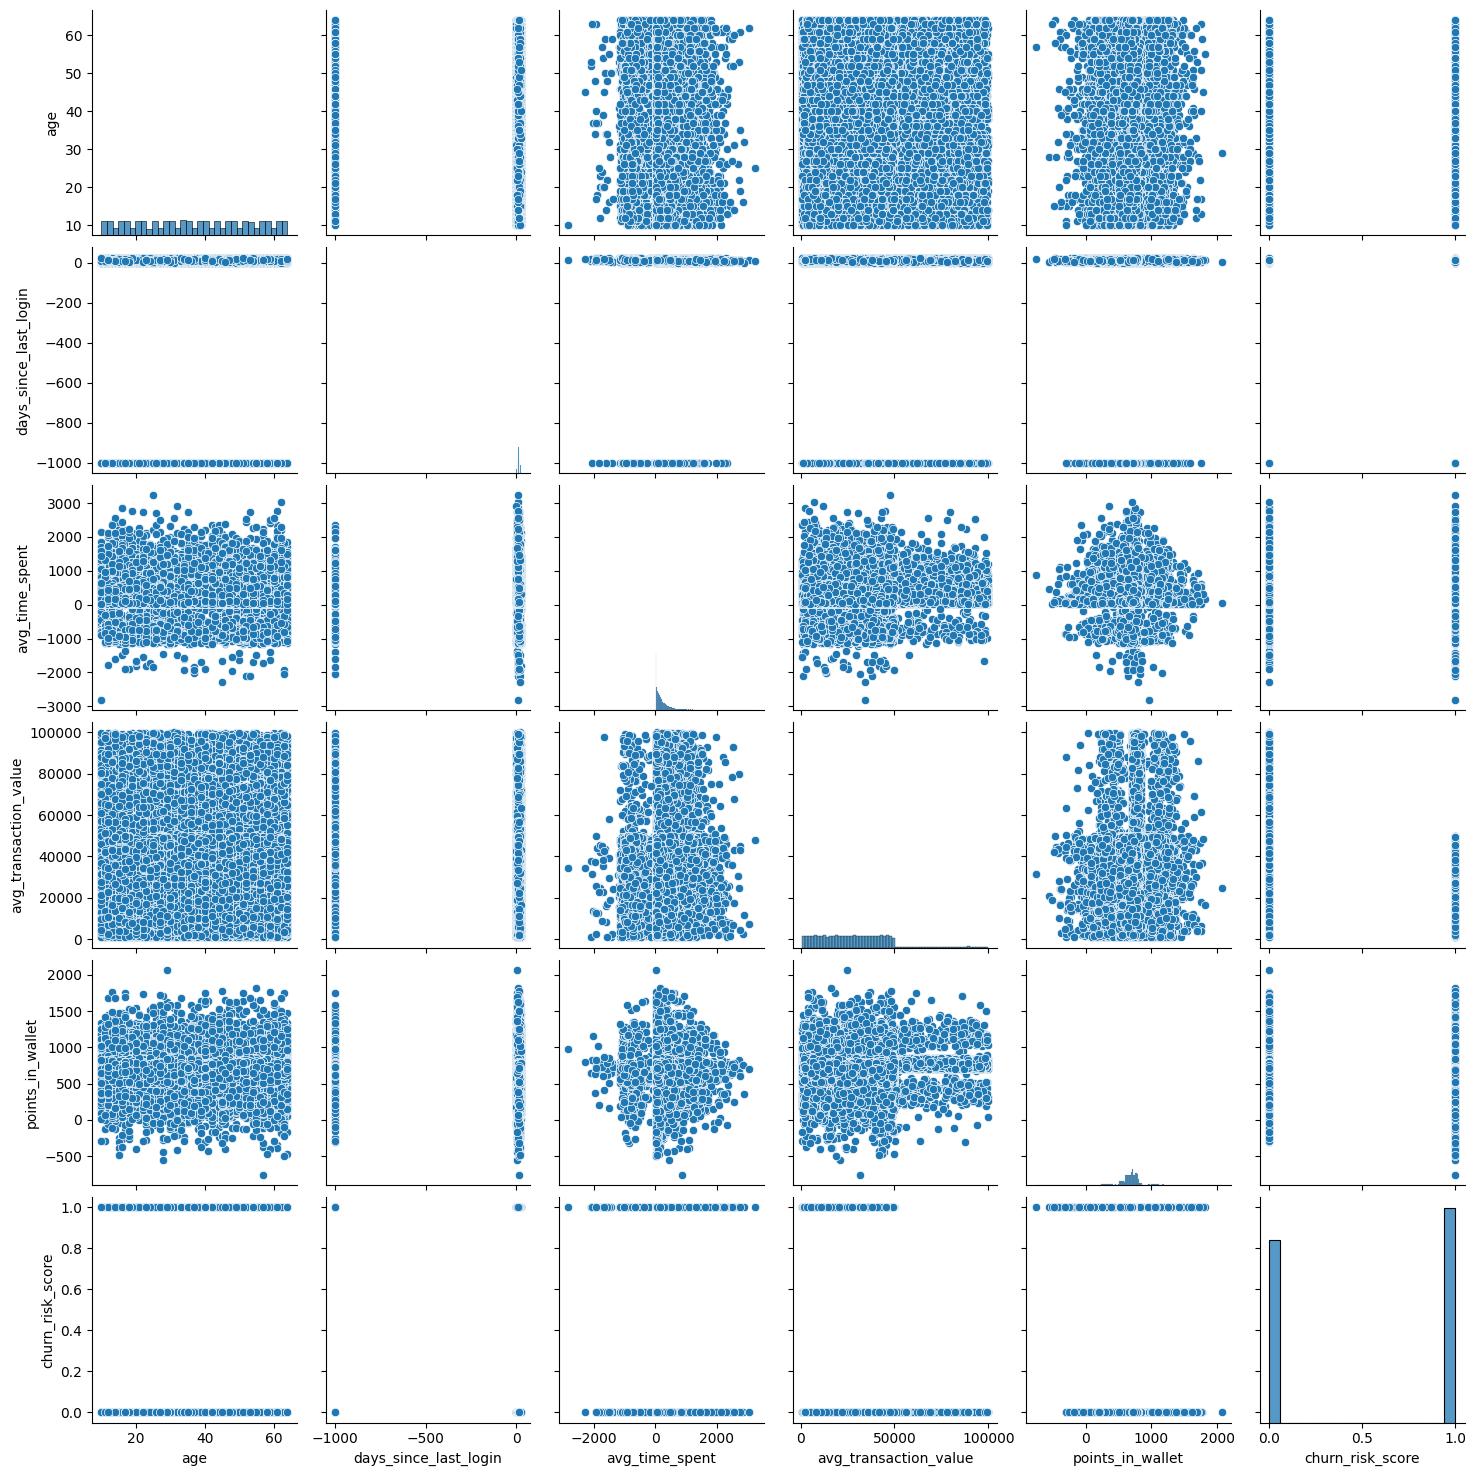

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.pairplot(df[numeric_columns])
plt.show()

Considerando as correlações obtidas na seção anterior, e em relação ao gráfico de dispersão *points_in_wallet* x *churn_risk_score*, percebe-se que usuários com cerca de -480 pontos para baixo possuem 100% de chance de deixarem o banco. E em relação ao gráfico *avg_transaction_value* x *churn_risk_score*, não há risco de usuários com aproximadamente mais de 50.000 de média de valor de transação saírem do banco. Nos demais gráficos não foram identificadas informações relevantes, uma vez que não apresentam algum tipo de relação clara.

### Análise e pré-processamento das colunas

#### Unnamed:0, security_no e referral_id

As colunas *unnamed:0*, *security_no* e *referral_id* são informações de identificação, logo podem ser retiradas do *dataset*.

In [10]:
df = df.drop(['Unnamed: 0','security_no','referral_id'],axis=1)
df.head()

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,Village,Platinum Membership,2017-08-17,No,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,32,F,City,Premium Membership,2017-08-28,?,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,44,F,Town,No Membership,2016-11-11,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,37,M,City,No Membership,2016-10-29,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,1
4,31,F,City,No Membership,2017-09-12,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,1


#### Age



##### Analisando o comportamento de faixas de idade em relação ao churn

###### Faixas de idades definidas automáticamente pelo histograma

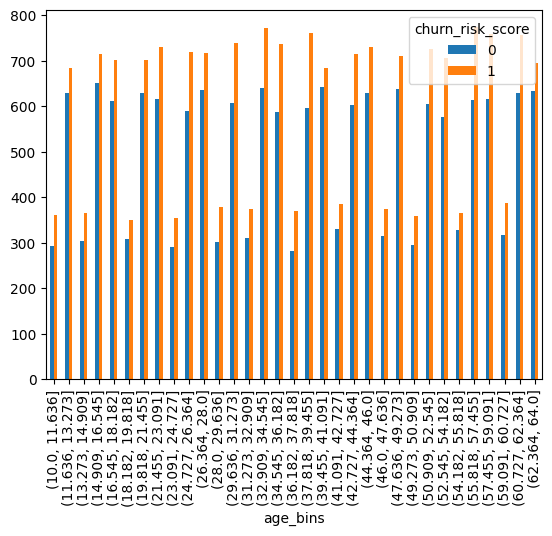

In [11]:
import numpy as np

hist, bins = np.histogram(df['age'], bins='auto')
bins = pd.cut(df['age'], bins=bins)
df['age_bins'] = bins
grouped_df = df.groupby(['age_bins', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

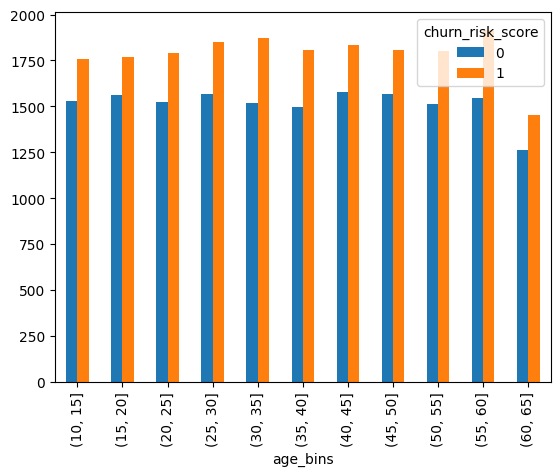

In [12]:
import numpy as np

bins = pd.cut(df['age'], bins=[i for i in range(min(df['age']),max(df['age']) + 6,5)])
df['age_bins'] = bins
grouped_df = df.groupby(['age_bins', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

<Axes: title={'center': 'age'}, xlabel='churn_risk_score'>

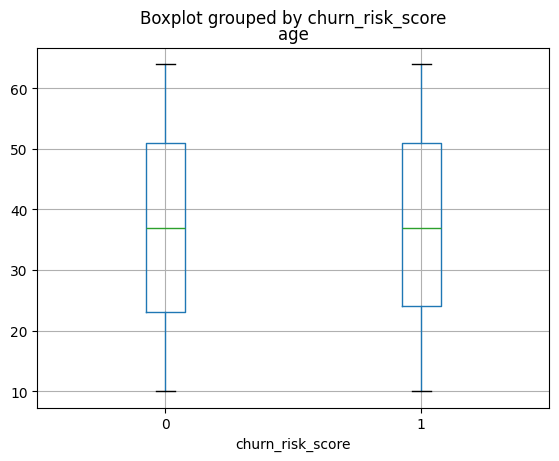

In [13]:
df.boxplot('age',by='churn_risk_score')

Os gráficos acima mostram que aplicar técnicas de *binning* possivelmente não ajudarão o modelo a tomar melhores decisões, uma vez que para todas as faixas de idade a quantidade de pessoas que deixam o banco e não deixam está próxima, ou seja, não influencia o churn.

Como a tabela na seção Descrição Estatística dos Dados Numéricos mostra que a maioria dos atributos contém valores diferentes em relação a escala, ou seja, potencialmente se benficiarão do ajuste de escala, o atributo *age* também será normalizado para ficar na mesma escala dos demais atributos.

#### Gender

##### Verificando valores únicos

In [14]:
df['gender'].unique()

array(['F', 'M', 'Unknown'], dtype=object)

##### Contando quantidade de cada valor

In [15]:
df.groupby('gender')['age'].count()

gender
F          18490
M          18443
Unknown       59
Name: age, dtype: int64

##### Analisando a relação do gênero e o churn para cada valor

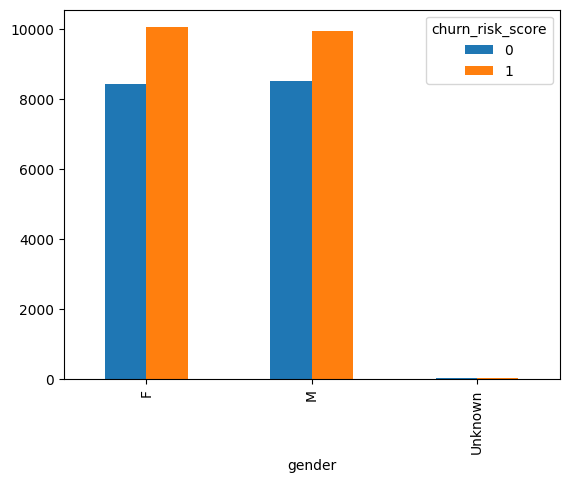

In [16]:
grouped_df = df.groupby(['gender', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

O gráfico de barras acima mostra que não há uma tendência de churn tanto para usuários do mesmo sexo quanto para usuários de gêneros diferentes, uma vez que os valores para cada gênero de churn e não churn estão relativamente próximos. Em análises posteriores, ao dizer que um atributo não influencia o churn, analogamente considere que esta explicação implícitamente a acompanha.

Como para diferentes gêneros não há uma relação entre a saída ou não do banco e a quantidade de gêneros desconhecidos é muito pequena, as observações com valor *unknown* serão retiradas do dataset. Após isso, os gêneros serão mapeados para valores binários. Inicialmente esta técnica foi escolhida para não aumentar a dimensionalidade dos dados, e caso posteriormente o modelo não apresente bons resultados, outras técnicas de transformações de dados categóricos serão aplicadas.



#### Region category

##### Verificando valores únicos

In [17]:
df['region_category'].unique()

array(['Village', 'City', 'Town', nan], dtype=object)

O atributo *region_category* contém cerca de 5000 dados nulos. Para evitar excluir esta quantidade de dados, foi analisado para todos os outros atributos categóricos se existe alguma relação de uma pessoa ser de uma determinada região e pertencer a outra classe do outro atributo, para que fosse possível mapear os valores *nan*. Por ex., foi analisado se existe uma tendência de pessoas da cidade realizarem feedback negativos enquanto pessoas da vila darem um feedbacks positivos, ou vice-versa. No entanto, não foi encontrada este tipo de relação para qualquer outro atributo. Assim, observações com valores *nan* serão retirados do dataset.

##### Analisando a relação da região e o churn para cada valor

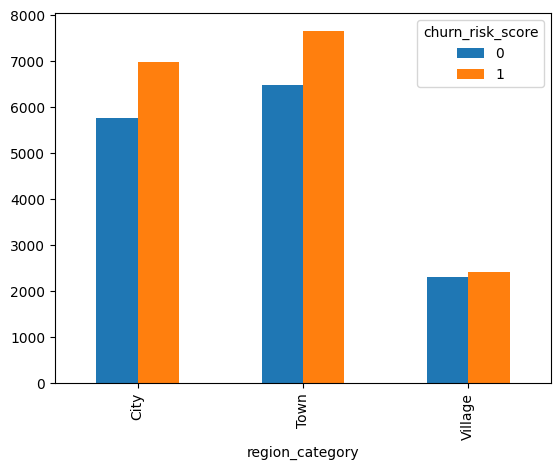

In [18]:
grouped_df = df.groupby(['region_category', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Também não uma relação explícita entre a região e a saída do usuário do banco. Para manter a dimensionalidade dos dados, inicialmente cada categoria será mapeada para um valor numérico.

#### Membership category

##### Verificando valores únicos

In [19]:
df['membership_category'].unique()

array(['Platinum Membership', 'Premium Membership', 'No Membership',
       'Gold Membership', 'Silver Membership', 'Basic Membership'],
      dtype=object)

##### Analisando a relação da região e o churn para cada valor deste atributo

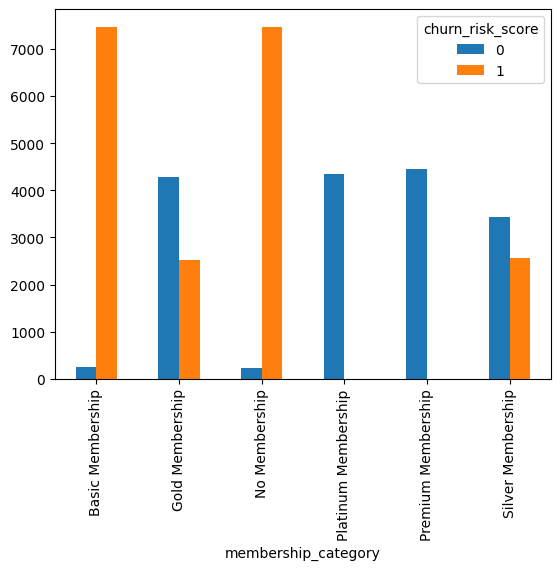

In [20]:
grouped_df = df.groupby(['membership_category', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

O gráfico de barras acima mostra que membros afiliados de maior hierarquia (platinum e premium) não tendem a sair do banco, enquanto os de menor hierarquia (básica e sem afiliação) tem uma grande tendência em sair do banco. Já usuários nos planos silver e gold não tem uma tendência explícita, sendo necessário outros atributos para prever a tendência de churn.

Assim , membros platinum e gold serão mapeados para uma categoria alta, membros sem afiliação e de afiliação básica serão mapeados para uma categoria baixa, e membros silver e gold serão mapeados para uma categoria intermediária.

#### Joining date

Abaixo será analisado se o dia, mês e ano possuem alguma relação com a saída do usuário do banco.

##### Separando data em ano, mês e dia

In [21]:
df[['ano', 'mes', 'dia']] = df['joining_date'].str.split('-', expand=True)
df[['joining_date','ano', 'mes', 'dia']].head()

,joining_date,ano,mes,dia
0,2017-08-17,2017,08,17
1,2017-08-28,2017,08,28
2,2016-11-11,2016,11,11
3,2016-10-29,2016,10,29
4,2017-09-12,2017,09,12


##### Gráfico de barras ano x churn

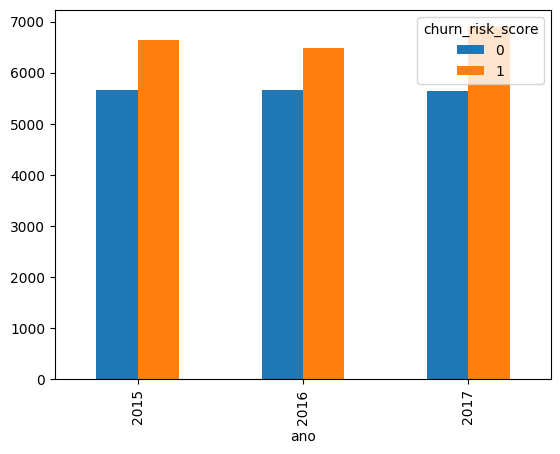

In [22]:
grouped_df = df.groupby(['ano', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Como são apenas três anos no dataset, estes valores serão considerados como atributos categóricos.

##### Gráfico de barras mês x churn

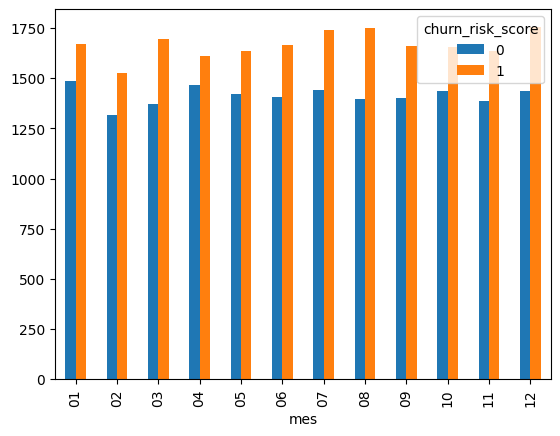

In [23]:
grouped_df = df.groupby(['mes', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Já os meses, como são 12, estes valores serão normalizados.

##### Gráfico de barras dia x churn

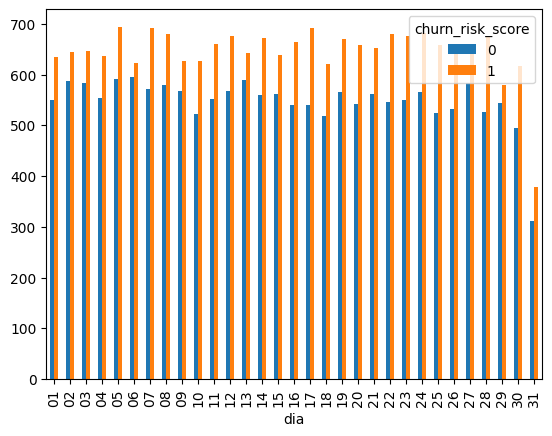

In [24]:
grouped_df = df.groupby(['dia', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

De acordo com os gráficos acima, as datas não possuem uma relação direta com o churn do usuário. Além disso, o atributo dia dificilmente irá contribuir para o resultado do modelo, portanto será desconsiderado para treinamento.

#### Joined through referral

##### Verificando valores únicos

In [25]:
df['joined_through_referral'].unique()

array(['No', '?', 'Yes'], dtype=object)

##### Analisando a relação de cada valor com o churn

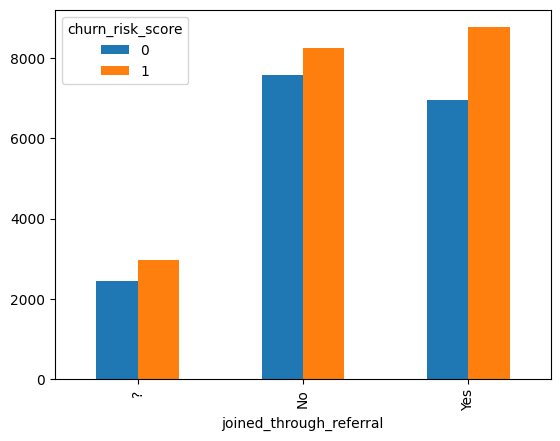

In [26]:
grouped_df = df.groupby(['joined_through_referral', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Para cada valor deste atributo também não existe uma relação explícita de churn. Cada valor deste atributo será mapeado para um valor numérico.

#### Preferred offer types

##### Verificando valores únicos

In [27]:
df['preferred_offer_types'].unique()

array(['Gift Vouchers/Coupons', 'Credit/Debit Card Offers',
       'Without Offers', nan], dtype=object)

As observações com valores nulos serão retiradas do *dataset*.

##### Analisando a relação de cada valor com o churn

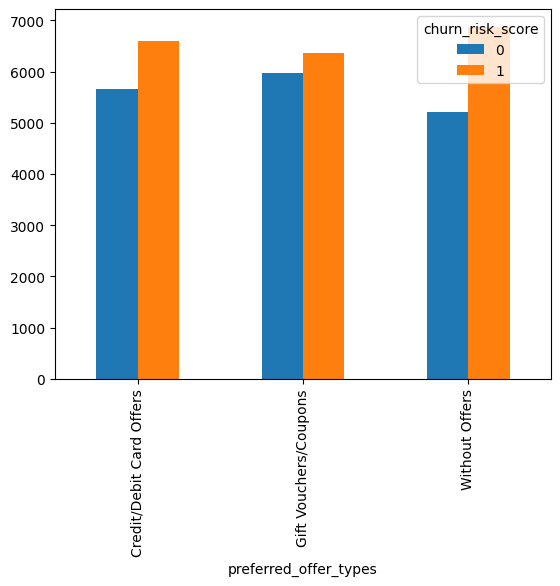

In [28]:
grouped_df = df.groupby(['preferred_offer_types', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Este atributo também não apresenta uma influência ao churn do usuário.

#### Medium of operation

##### Analisando valores únicos

In [29]:
df['medium_of_operation'].unique()

array(['?', 'Desktop', 'Smartphone', 'Both'], dtype=object)

##### Analisando a relação de cada valor com o churn

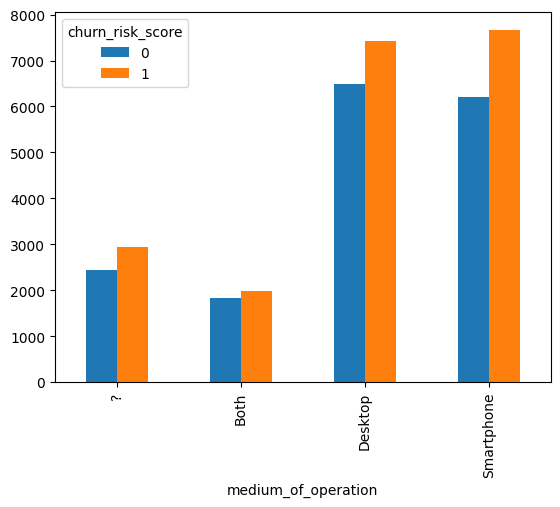

In [30]:
grouped_df = df.groupby(['medium_of_operation', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Este atributo também não apresenta uma influência direta ao churn do usuário.

#### Internet option

##### Analisando valores únicos

In [31]:
df['internet_option'].unique()

array(['Wi-Fi', 'Mobile_Data', 'Fiber_Optic'], dtype=object)

##### Analisando a relação de cada valor com o churn

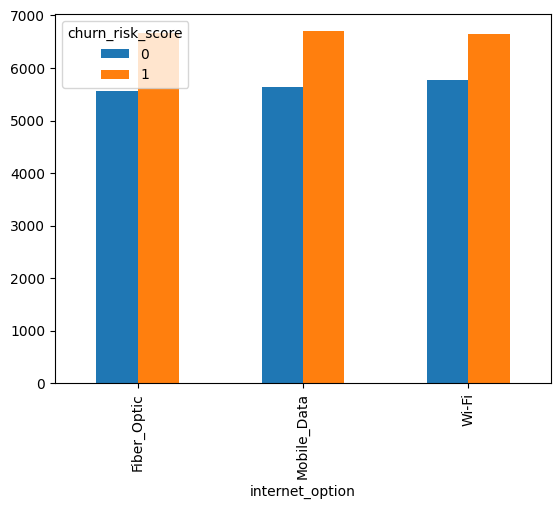

In [32]:
grouped_df = df.groupby(['internet_option', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Este atributo também não apresenta uma influência direta ao churn do usuário.

#### Last visit time

##### Analisando se todos os valores estão no formato hh:mm:ss

In [33]:
len(df[df['last_visit_time'].str.contains(':')]) == len(df)

True

##### Separando em hora, minuto e segundo

In [34]:
df[['hora', 'minuto', 'segundo']] = df['last_visit_time'].str.split(':', expand=True)
df[['last_visit_time','hora', 'minuto', 'segundo']].head()

,last_visit_time,hora,minuto,segundo
0,16:08:02,16,08,02
1,12:38:13,12,38,13
2,22:53:21,22,53,21
3,15:57:50,15,57,50
4,15:46:44,15,46,44


##### Gráfico de barras hora x churn

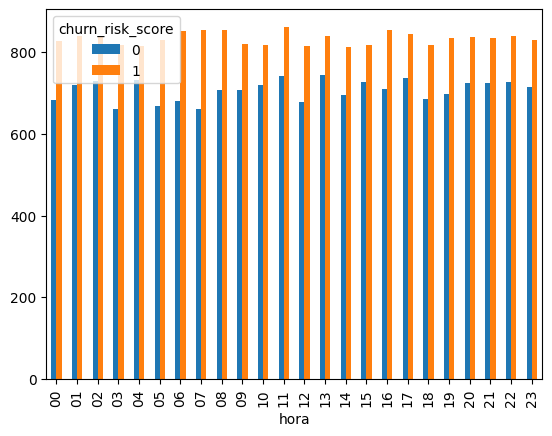

In [35]:
grouped_df = df.groupby(['hora', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

##### Gráfico de barras minuto x churn

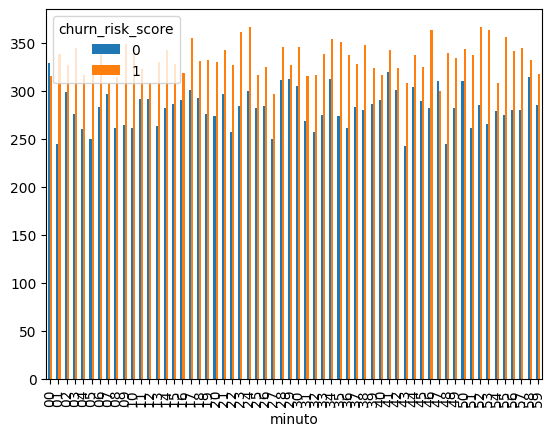

In [36]:
grouped_df = df.groupby(['minuto', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

##### Gráfico de barras segundo x churn

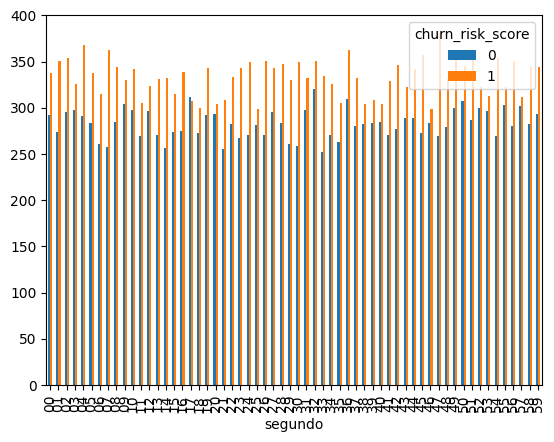

In [37]:
grouped_df = df.groupby(['segundo', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Nenhum dos atributos derivados de *last_visit_time* possui uma relação explícita com o churn do usuário. Inicialmente estes atributos serão desconsiderados para treinamento, uma vez que dificilmente causarão alguma influência no churn do usuário.

#### Days since last login

##### Verificando valores únicos

In [38]:
df['days_since_last_login'].unique()

array([  17,   16,   14,   11,   20,   23,   10,   19,   15,   13, -999,
          5,   12,    9,   21,   18,    1,   22,    4,    8,    3,    6,
          2,   24,    7,   26,   25])

O valor -999 para esta coluna possivelmente apresenta uma anomalia ou indica que um usuário não realiza o login a muito tempo. Pessoas que não realizam o login a muito tempo possivelmente deixaram o banco, assim, esta hipótese sera analisada na próxima célula.

<Axes: xlabel='churn_risk_score'>

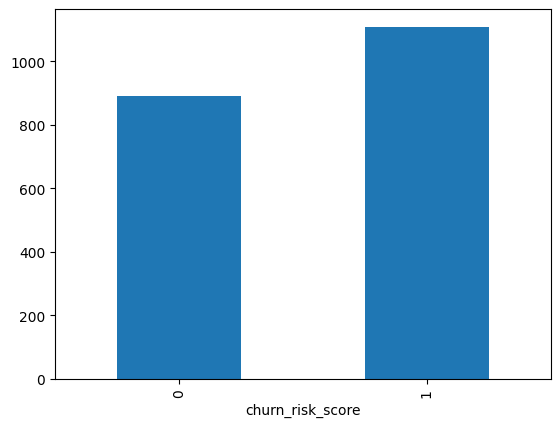

In [39]:
df[df['days_since_last_login'] == - 999].groupby('churn_risk_score').count()['age'].plot(kind='bar')

O gráfico acima mostra que não há uma tendência forte de observações com valor -999 deixarem o banco, uma vez que o estas observações contém quantidades próxima de usuários que deixaram e não deixaram o banco. Uma média será calculada para as observações com valores positivos e as observações com valor -999 terão seus valores substituídos pela média. Após isso, este dado será normalizado, pelo mesmo motivo dos outros atributos numéricos.

##### Analisando a possibilidade de churn com o aumento dos dias sem acesso ao aplicativo

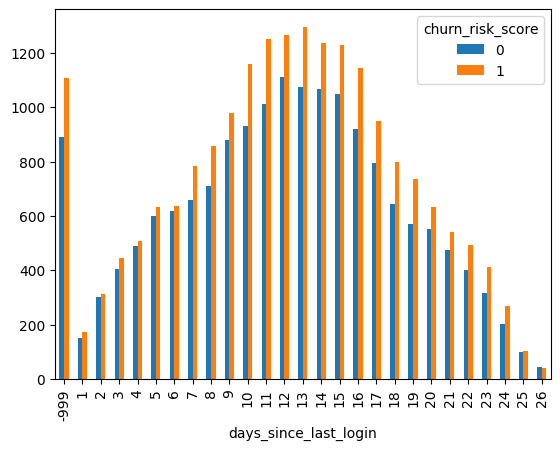

In [40]:
grouped_df = df.groupby(['days_since_last_login', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Não há uma tendência explícita entre os dias sem utilizar o aplicativo e o churn.

#### Avg transaction value

Como apresentado nos gráficos de dispersão, usuários com um alto valor médio de transação possuem uma forte tendência em não deixar o banco, portanto este atributo será transformado da seguinte forma: valores aproximadamente acima de 50.000 (de acordo com o gráfico) serão substituídos pelo valor mais alto, e logo após, os valores serão normalizados. A ideia é que estes valores indiquem um mesmo grupo de usuários (com baixa tendência de churn') ao mesmo tempo que cada outro valor possa ser usado distintamente pelo modelo para prever o churn.

#### Avg time spent

De acordo com os gráficos apresentados para os atributos numéricos, o ideal a fazer com este atributo normalizar os seus valores, uma vez que este atributo possui uma distribuição de cauda longa.

#### Avg frequency login days

O atributo *avg_frequency_login_days* contém valores com a string 'Error'. Caso as observações com este valor não apresentem uma influência no churn do usuário, o valor da média desta coluna será utilizado para substituí-lo.

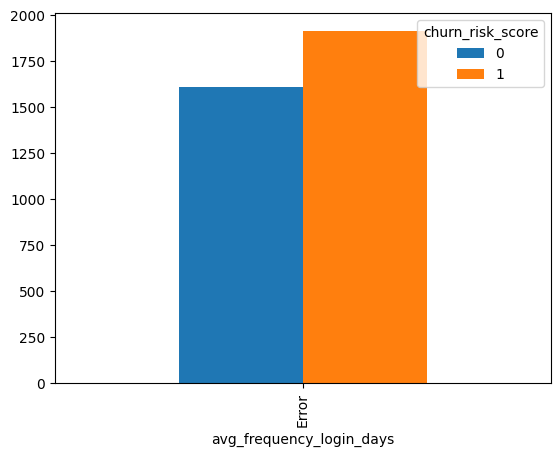

In [41]:
grouped_df = df[df['avg_frequency_login_days'] == 'Error'].groupby(['avg_frequency_login_days', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

De acordo com o gráfico acima, este atributo não influencia o churn do usuário por si só.

####  Used special discount

##### Verificando valores únicos

In [42]:
df['used_special_discount'].unique()

array(['Yes', 'No'], dtype=object)

##### Analisando o seu impacto no churn

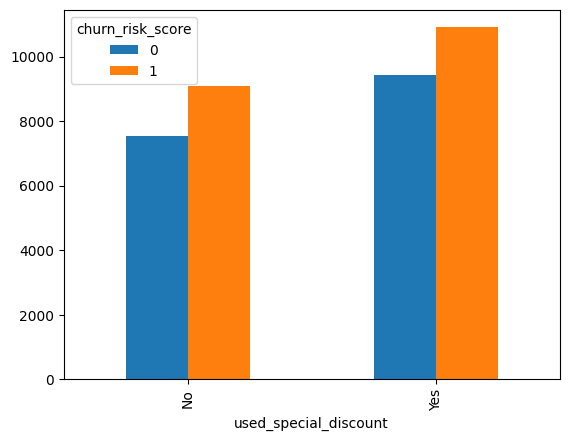

In [43]:
grouped_df = df.groupby(['used_special_discount', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Este atributo também não influencia o churn diretamente.

#### Points in Wallet

##### Boxplot dos pontos na carteira para usuários com alto e baixo risco de churn

<Axes: title={'center': 'points_in_wallet'}, xlabel='churn_risk_score'>

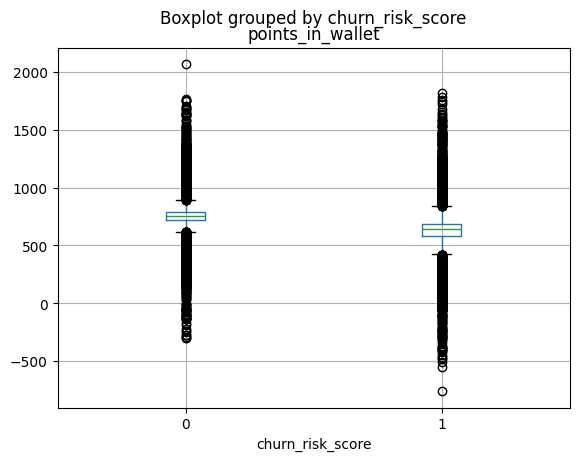

In [44]:
df.boxplot('points_in_wallet',by='churn_risk_score')

O boxplot acima mostra que usuários com baixos e elevados valores de pontos na carteira podem ou não deixar banco, com exceção para valores negativos no extremo, indicando que estes usuários tendem a deixar o banco. Além disso, a maioria das observações possuem valores para esta coluna entre 500 e 800, aproximadamente. O ideal a se fazer com este atributo é normalizá-lo.

#### Offer application preference

##### Verificando valores únicos

In [45]:
df['offer_application_preference'].unique()

array(['Yes', 'No'], dtype=object)

##### Analisando a tendência de churn e não churn para cada valor

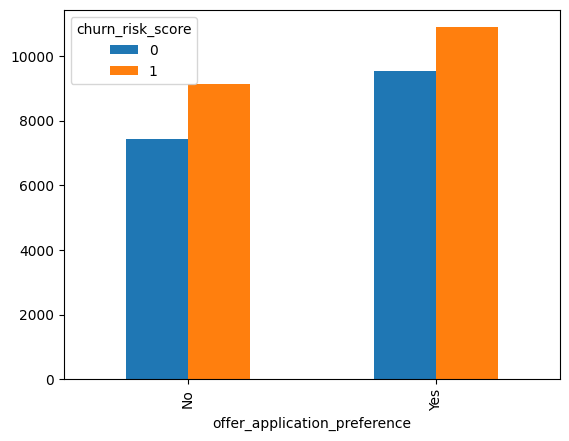

In [46]:
grouped_df = df.groupby(['offer_application_preference', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Aqui também não há uma tendência direta de churn ou não churn.

#### Past complaint

##### Verificando valores únicos

In [47]:
df['past_complaint'].unique()

array(['No', 'Yes'], dtype=object)

##### Analisando a tendência de churn e não churn para cada valor

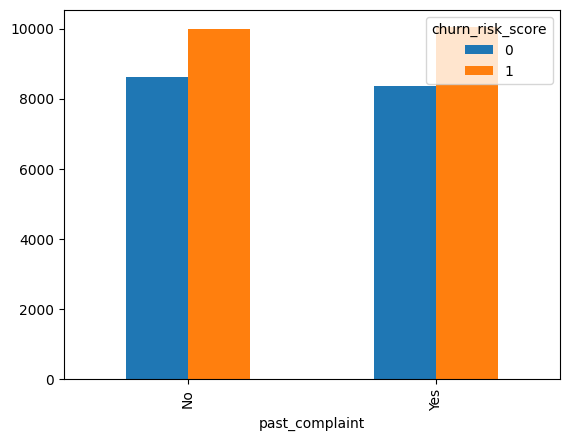

In [48]:
grouped_df = df.groupby(['past_complaint', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Aqui também não há uma tendência explícita.

#### Complaint status

###### Verificando valores únicos

In [49]:
df['complaint_status'].unique()

array(['Not Applicable', 'Solved', 'Solved in Follow-up', 'Unsolved',
       'No Information Available'], dtype=object)

##### Analisando a tendência de churn e não churn para cada valor

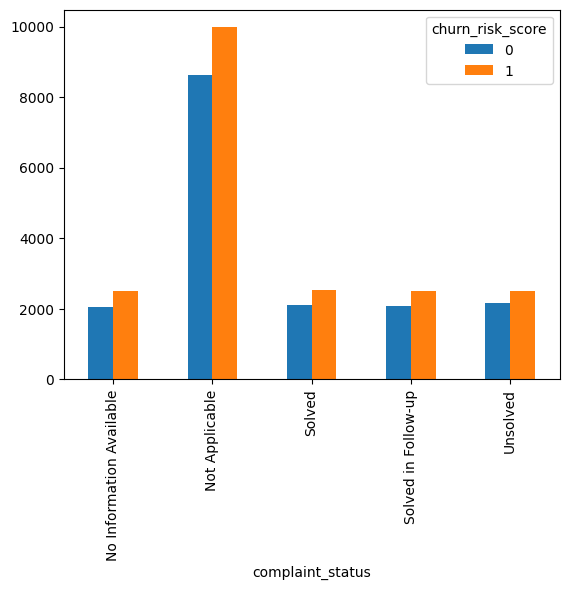

In [50]:
grouped_df = df.groupby(['complaint_status', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

Aqui também não há uma tendência explícita.

#### Feedback

##### Verificando valores únicos

In [51]:
df['feedback'].unique()

array(['Products always in Stock', 'Quality Customer Care',
       'Poor Website', 'No reason specified', 'Poor Product Quality',
       'Poor Customer Service', 'Too many ads', 'User Friendly Website',
       'Reasonable Price'], dtype=object)

##### Analisando a tendência de churn e não churn para cada valor

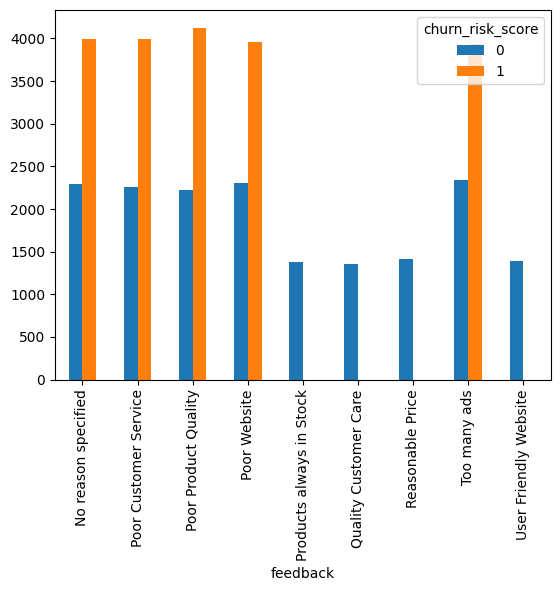

In [52]:
grouped_df = df.groupby(['feedback', 'churn_risk_score'])['age'].count().unstack()
grouped_df.plot(kind='bar')
plt.show()

O gráfico de barras acima mostram que clientes que postaram feedback positivos tem extrema tendência em continuar no banco, enquanto os que postaram feedbacks negativos tem uma alta tendência em deixar o banco. Os valores que representam feedbacks positivos serão mapeados para uma categoria, enquanto valores que apresentam feedbacks negativos serão mapeados categorias diferentes.

#### Resumo e conclusão da análise exploratória
##### Resumo
* Atributos de identificação (*unnamed:0, security_no* e *referral_id*) foram removidos do *dataset*;

* Os únicos atributos que possuem algum nível de influência no atributo *churn_risk_score* são: *points_in_wallet, avg_transaction_value, member_ship_category* e *feedback*;

* Atributos com valores nulos, anômalos ou irrelevantes terão os seus valores transformados para outra categoria de acordo com a similaridade das observações com a média de cada categoria;

* Em cada seção de análise dos atributos é apresentado o método escolhido para transformação dos dados, as quais serão feitas na etapa de engenharia de atributos;

* Atributos como o dia (derivado de *joining_date*), hora, minuto e segundo (derivados de *last_visit_time*) serão desconsiderados, uma vez que potencialmente não vão fornecer uma melhoria nos resultados, além de que atributos como ano e mês já estão sendo considerados.

##### Conclusão
* Poucos atributos apresentaram uma influência direta com o churn do usuário. Assim, será necessário aplicar técnicas de seleção de atributos para decidir se os atributos que não causam influência direta no atributo *churn_risk_score* serão utilizados no modelo.

## Engenharia de Atributos

Os códigos abaixo transformam os atributos de acordo com as discussões realizada sobre cada um na análise exploratória. Vale ressaltar que para realizar a análise exploratória de alguns atributos como *joinin_date* e *last_visit_time*, uma transformação nos atributos originais já foram realizadas.

#### Gender

##### Retirando observações com valores *unknown*

In [53]:
df_v1 = df[(df['gender']=='M') | (df['gender']=='F')]
print(len(df_v1))

36933


#### Retirando observações com valores *nan*

In [54]:
df_v1 = df_v1.dropna(axis=0).reset_index().drop('index',axis=1)
print(len(df_v1))

27824


#### Membership category

Transformação dos dados de acordo com o nível de hierarquia. Visitar a análise exploratória deste atributo para mais detalhes.

In [55]:
def transform_membership_category(df):
    df.loc[(df['membership_category'] == 'Platinum Membership') | (df['membership_category'] =='Premium Membership'), 'membership_category'] = 0
    df.loc[(df['membership_category'] == 'No Membership') | (df['membership_category'] =='Basic Membership'), 'membership_category'] = 1
    df.loc[(df['membership_category'] == 'Silver Membership') | (df['membership_category'] =='Gold Membership'), 'membership_category'] = 2
    return df
df_v1 = transform_membership_category(df_v1)

#### Days since last login
Mapeamento dos valores com valor -999 para a média das observações desta coluna, considerando apenas os valores positivos.

In [56]:
filter = df_v1[df_v1['days_since_last_login'] >= 0]
mean_value = filter['days_since_last_login'].mean().item()
df_v1.loc[df_v1['days_since_last_login'] < 0,'days_since_last_login'] = mean_value
assert len(df_v1[df_v1['days_since_last_login'] < 0]) == 0

#### Avg transaction value
Transformação das observações com valores maiores ou iguais a 50.000 para o maior valor desta coluna.

In [57]:
max_value = df_v1['avg_transaction_value'].max()
df_v1.loc[df_v1['avg_transaction_value'] >= 50000,'avg_transaction_value'] = max_value
assert len(df_v1[(df_v1['avg_transaction_value'] >= 50000) & (df_v1['avg_transaction_value'] < max_value)]) == 0

#### Avg frequency login days

Mapeamento dos valores com valor 'Error' para a média das observações desta coluna.

In [58]:
filter = df_v1[df_v1['avg_frequency_login_days'] != 'Error']
filter['avg_frequency_login_days'] = filter['avg_frequency_login_days'].astype(float)
mean_value = filter['avg_frequency_login_days'].mean().item()
df_v1.loc[df_v1['avg_frequency_login_days'] == 'Error','avg_frequency_login_days'] = mean_value
df_v1['avg_frequency_login_days'] = df_v1['avg_frequency_login_days'].astype(float)
assert len(df_v1[df_v1['avg_frequency_login_days'] == 'Error']) == 0

#### Feedback
Mapeamento das observações com feedback positivo para uma categoria, e o restante para categorias diferentes.

In [59]:
def transform_feedback(df):
       bad_feedbacks = [ 'Poor Website', 'No reason specified', 'Poor Product Quality',
              'Poor Customer Service', 'Too many ads']
       good_feedbacks = ['Products always in Stock', 'Quality Customer Care','User Friendly Website','Reasonable Price']
       for value in good_feedbacks:
              df.loc[df['feedback'] == value,'feedback'] = 0
       count =  1
       for value in bad_feedbacks:
              df.loc[df['feedback'] == value,'feedback'] = count
              count+=1
       df['feedback'] = df['feedback'].astype(str)
       return df
df_v1 = transform_feedback(df_v1)

#### Transformando demais colunas categóricas

As colunas transformadas abaixo serão mapeadas para um valor numérico representado a sua determinada categoria. Inicialmente, esta escolha foi tomada pois não foi encontrada uma relação entre os dados que permitisse outra transformação (como em *membership_category*) e também para não aumentar a dimensionalidade dos dados. Posteriormente, se os resultados não forem bons,
outros métodos de transformações serão abordados.

In [60]:
categorical_columns = ['internet_option','region_category','gender','ano','preferred_offer_types','joined_through_referral','medium_of_operation','used_special_discount','offer_application_preference','past_complaint','complaint_status']
for col in categorical_columns:
  df_v1[col] = pd.factorize(df_v1[col])[0]
df_v1.head(3)

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,...,complaint_status,feedback,churn_risk_score,age_bins,ano,mes,dia,hora,minuto,segundo
0,18,0,0,0,2017-08-17,0,0,0,0,16:08:02,...,0,0,0,"(15, 20]",0,08,17,16,08,02
1,44,0,1,1,2016-11-11,1,0,1,0,22:53:21,...,1,1,1,"(40, 45]",1,11,11,22,53,21
2,37,1,2,1,2016-10-29,1,0,1,1,15:57:50,...,2,1,1,"(35, 40]",1,10,29,15,57,50


#### Normalizando atributos numéricos

In [61]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = ['age','mes','days_since_last_login','avg_transaction_value','avg_time_spent','points_in_wallet']

scaler = StandardScaler()
df_v1[columns_to_scale] = scaler.fit_transform(df_v1[columns_to_scale])
df_v1[columns_to_scale].head()

,age,mes,days_since_last_login,avg_transaction_value,avg_time_spent,points_in_wallet
0,-1.253668,0.426544,0.785064,2.826844,0.141456,0.481506
1,0.412081,1.297133,0.231525,-0.423349,0.678384,-0.966350
2,-0.036390,1.006937,-0.322014,-0.249789,-0.474768,-0.621360
3,-0.420794,0.716740,1.338603,-0.280932,-0.325644,-0.129915
4,-1.574005,-1.604830,1.892142,-0.717613,0.472760,0.175100


## Treinamento e Seleção de Atributos

### Método de treinamento

O treinamento abordado para a classificação de churn é o seguinte: o modelo será treinado inicialmente com os atributos identificados na etapa de análise exploratória que causam algum nível de influência no churn. Após isso, um novo modelo será treinado com o acréscimo iterativo dos outros atributos em ordem de maior probabilidade de influenciar o churn do usuário, definido subjetivamente de acordo com a sua relação com o domínio do problema. Ao final do treinamento será possível avaliar o impacto da inserção de cada feature no resultado do modelo. Assim, a seleção de atributos é feita empiricamente de acordo com estes resultados.

Vale ressaltar que a métrica utilizada como avaliação do modelo foi o valor AUC.

### Funções de treinamento

In [62]:
from copy import deepcopy
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.model_selection import  cross_validate
import math
from sklearn import svm

def train_with_grid_search(model,params,features,labels):
    grid_search = GridSearchCV(model, params, cv=10, scoring='roc_auc')
    return grid_search.fit(features, labels.values.ravel())

def train_with_cross_validation(model,features,labels):
    result = cross_validate(model, features, labels, cv=10,scoring='roc_auc',return_estimator=True,return_train_score=True)
    test_scores = result['test_score']
    best_class = result['estimator'][np.argmax(test_scores)]
    return test_scores,best_class

def split_data_in_train_test(df):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train = df_train.reset_index().drop('index',axis=1)
    df_test = df_test.reset_index().drop('index',axis=1)
    return df_train,df_test

# Treina os modelos com validação cruzada e acrescentando as features iterativamente,como descrito no início da seção
def train(df, feature_columns_to_train,feature_columns_to_increment,label_column):
  best_auc = -math.inf
  best_model = None
  best_features = None
  df_train, df_test = split_data_in_train_test(df)
  for feat in [None]+feature_columns_to_increment:
    if feat != None:
      feature_columns_to_train.append(feat)
    scores, best_class = train_with_cross_validation(svm.SVC(),
              df_train[feature_columns_to_train], df_train[label_column].values.ravel())
    auc = np.mean(scores)
    if  auc > best_auc:
      best_auc = auc
      best_model = best_class
      best_features = deepcopy(feature_columns_to_train)
    print(f'Melhor valor AUC médio ao acrescentar a feature {feat}: ',auc)
  return best_model, df_test,best_features

### Funções de avaliação

In [63]:
from sklearn.metrics import classification_report

def evaluate(model,features,labels):
    out = model.predict(features)
    return classification_report(labels,out)

### Definindo atributos para treinamento

In [64]:
feature_columns_to_train = ['feedback','points_in_wallet','membership_category','avg_transaction_value']
feature_columns_to_increment = ['age','complaint_status','past_complaint','ano','mes','days_since_last_login','gender',
                                'region_category','joined_through_referral','used_special_discount','offer_application_preference',
                                'preferred_offer_types','avg_frequency_login_days','avg_time_spent','medium_of_operation','internet_option']
label_column = ['churn_risk_score']

### Treinamento 1

In [65]:
best_model, df_test, best_features = train(df_v1,feature_columns_to_train,feature_columns_to_increment,label_column)

Melhor valor AUC médio ao acrescentar a feature None:  0.9423083444940138
Melhor valor AUC médio ao acrescentar a feature age:  0.9419267013386768
Melhor valor AUC médio ao acrescentar a feature complaint_status:  0.9419667184969043
Melhor valor AUC médio ao acrescentar a feature past_complaint:  0.942020182733612
Melhor valor AUC médio ao acrescentar a feature ano:  0.9417696119428104
Melhor valor AUC médio ao acrescentar a feature mes:  0.9424611191881771
Melhor valor AUC médio ao acrescentar a feature days_since_last_login:  0.9428493299330725
Melhor valor AUC médio ao acrescentar a feature gender:  0.9431446557588684
Melhor valor AUC médio ao acrescentar a feature region_category:  0.9433538028260535
Melhor valor AUC médio ao acrescentar a feature joined_through_referral:  0.943174432727844
Melhor valor AUC médio ao acrescentar a feature used_special_discount:  0.9431130469369033
Melhor valor AUC médio ao acrescentar a feature offer_application_preference:  0.9431916631649381
Melho

#### Resultados do treinamento 1

Antes de discutir sobre os resultados do treinamento, vale destacar que o acréscimo da feature None significa que nenhum atributo foi adicionado, ou seja, foram utilizados apenas os atributos na váriavel  *feature_columns_to_train*.

O treinamento acima mostra que o modelo não se beneficiou significativamente ao utilizar outros atributos no treinamento, ou seja, somente as features *feedback*, *points_in_wallet, membership_category, avg_transaction_value* são suficientes para que o modelo obtenha bons resultados. Dessa forma, como a dimensionalidade dos dados foi reduzida para apenas 4 features, no treinamento 2 serão feitas transformações one-hot encoding nos dados categóricos escolhidos. Após isso, o melhor modelo obtido será utilizado no ajuste de hiper-parâmetros.


#### Avaliação do melhor modelo obtido

In [66]:
print(evaluate(best_model,df_test[best_features],df_test[label_column]))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88      2562
           1       0.87      0.96      0.91      3003

    accuracy                           0.90      5565
   macro avg       0.91      0.89      0.90      5565
weighted avg       0.91      0.90      0.90      5565



### Treinamento 2

Treinamento apenas com os atributos significativos para o modelo com transformação one-hot encoding.

#### Engenharia de atributos

##### Cópia do dataframe original

In [67]:
df_v2 = df.copy()[['feedback','membership_category','avg_transaction_value','points_in_wallet','churn_risk_score']]
df_v2.head(2)

,feedback,membership_category,avg_transaction_value,points_in_wallet,churn_risk_score
0,Products always in Stock,Platinum Membership,53005.25,781.75,0
1,Quality Customer Care,Premium Membership,12838.38,NaN,0


##### Retirando dados nulos

In [68]:
df_v2 = df_v2.dropna(axis=0)

##### Transformando atributo feedback

In [69]:
df_v2 = transform_feedback(df_v2)
df_v2.head()

,feedback,membership_category,avg_transaction_value,points_in_wallet,churn_risk_score
0,0,Platinum Membership,53005.25,781.75,0
2,1,No Membership,21027.00,500.69,1
3,1,No Membership,25239.56,567.66,1
4,1,No Membership,24483.66,663.06,1
5,2,Gold Membership,13884.77,722.27,0


##### Transformando atributo membership_category 

In [70]:
df_v2 = transform_membership_category(df_v2)
df_v2.head()

,feedback,membership_category,avg_transaction_value,points_in_wallet,churn_risk_score
0,0,0,53005.25,781.75,0
2,1,1,21027.00,500.69,1
3,1,1,25239.56,567.66,1
4,1,1,24483.66,663.06,1
5,2,2,13884.77,722.27,0


##### Normalizando atributos numéricos

In [71]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = ['avg_transaction_value','points_in_wallet']
scaler2 = StandardScaler()
df_v2[columns_to_scale] = scaler2.fit_transform(df_v2[columns_to_scale])
df_v2.head()

,feedback,membership_category,avg_transaction_value,points_in_wallet,churn_risk_score
0,0,0,1.221414,0.488856,0
2,1,1,-0.423717,-0.959453,1
3,1,1,-0.207001,-0.614355,1
4,1,1,-0.245888,-0.122756,1
5,2,2,-0.791151,0.182354,0


##### Aplicando one-hot encoding nos atributos categóricos

In [72]:
columns_one_hot_encoding = ['feedback','membership_category']
dummies = pd.get_dummies(df_v2[columns_one_hot_encoding])
df_v2 = pd.concat([df_v2, dummies], axis=1)
df_v2 = df_v2.drop(['feedback','membership_category'],axis=1)
df_v2.head()

,avg_transaction_value,points_in_wallet,churn_risk_score,feedback_0,feedback_1,feedback_2,feedback_3,feedback_4,feedback_5,membership_category_0,membership_category_1,membership_category_2
0,1.221414,0.488856,0,True,False,False,False,False,False,True,False,False
2,-0.423717,-0.959453,1,False,True,False,False,False,False,False,True,False
3,-0.207001,-0.614355,1,False,True,False,False,False,False,False,True,False
4,-0.245888,-0.122756,1,False,True,False,False,False,False,False,True,False
5,-0.791151,0.182354,0,False,False,True,False,False,False,False,False,True


#### Treinamento com validação cruzada

In [73]:
df_train, df_test = split_data_in_train_test(df_v2)
scores , best_svm = train_with_cross_validation(svm.SVC(),df_train.drop('churn_risk_score',axis=1),df_train[label_column])

##### Scores de cada validação cruzada

In [74]:
print(scores)
print('Média do valor AUC para o treinamento 2:', np.mean(scores))

[0.96802995 0.96606086 0.95214137 0.9550391  0.95944971 0.96147611
 0.95352693 0.94762766 0.95058764 0.94707711]
Média do valor AUC para o treinamento 2: 0.9561016441333898


#### Avaliação

In [75]:
print(evaluate(best_svm,df_test.drop('churn_risk_score',axis=1),df_test[label_column]))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3093
           1       0.93      0.95      0.94      3617

    accuracy                           0.94      6710
   macro avg       0.94      0.94      0.94      6710
weighted avg       0.94      0.94      0.94      6710



##### Resultados do treinamento 2

Nos resultados acima, percebe-se que aplicar one-hot encoding nos dados fez com que o modelo obtesse melhores resultados do que com as transformações da primeira versão. Portanto, o ajuste de hiper-parâmetros será feito com esta última transformação dos dados.

### Ajuste de hiperparâmetros com validação cruzada (Treinamento 3)

A célula abaixo foi comentada ao elevado tempo de execução. Caso queira executá-la, descomente.

In [76]:
# df_train, df_test = split_data_in_train_test(df_v2)
# gs = train_with_grid_search(svm.SVC(), {'C': [0.1,1,10,25,50], 'gamma': ['scale','auto'],
#                'degree':[1,2,3,4,5],
#                 'tol':[1e-3,1e-4],
#                'kernel': ['linear', 'rbf', 'poly','sigmoid']},df_train.drop(label_column[0],axis=1),df_train[label_column])
# print("Melhor parâmetro encontrado:", gs.best_params_ )

Melhor parâmetro encontrado: {C=0.1,kernel='poly',degree=3,'gamma='auto,tol=1e-3}

#### Treinamento e avaliação com o melhor hiperparâmetro encontrado

Apesar do Grid Search ter encontrado os hiper-parâmetros acima, o modelo obteve melhor resultado trocando o valor de C para 10 e tol=1e-4. Logo, este modelo será utilizado na seção de resultados para comparação.

##### C = 0.1 e tol = 1e-3

In [77]:
final_svm = svm.SVC(C=0.1,kernel='poly',degree=3,gamma='auto',tol=1e-3)
final_svm.fit(df_train.drop(label_column[0],axis=1),df_train[label_column].values.ravel())
print(evaluate(final_svm,df_test.drop(label_column,axis=1),df_test[label_column]))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      3093
           1       0.95      0.90      0.92      3617

    accuracy                           0.92      6710
   macro avg       0.92      0.92      0.92      6710
weighted avg       0.92      0.92      0.92      6710



##### C = 10 e tol = 1e-4

In [78]:
final_svm = svm.SVC(C=10,kernel='poly',degree=3,gamma='auto',tol=1e-4)
final_svm.fit(df_train.drop(label_column[0],axis=1),df_train[label_column].values.ravel())
print(evaluate(final_svm,df_test.drop(label_column,axis=1),df_test[label_column]))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3093
           1       0.95      0.94      0.94      3617

    accuracy                           0.94      6710
   macro avg       0.94      0.94      0.94      6710
weighted avg       0.94      0.94      0.94      6710



### Aplicando Auto-ML (TPOT)

#### Transformação dos dados categóricos

In [79]:
categorical_columns = ['membership_category','feedback','internet_option','region_category','gender','ano','preferred_offer_types','joined_through_referral','medium_of_operation','used_special_discount','offer_application_preference','past_complaint','complaint_status']
df_tpot = df.drop(['last_visit_time','joining_date','age_bins'],axis=1)
df_tpot = df_tpot.dropna().reset_index().drop('index',axis=1)
for col in categorical_columns:
  df_tpot[col] = pd.factorize(df_tpot[col])[0]
df_tpot.head(3)

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,...,past_complaint,complaint_status,feedback,churn_risk_score,ano,mes,dia,hora,minuto,segundo
0,18,0,0,0,0,0,0,0,17,300.63,...,0,0,0,0,0,08,17,16,08,02
1,44,0,1,1,1,0,1,0,14,516.16,...,1,1,1,1,1,11,11,22,53,21
2,37,1,2,1,1,0,1,1,11,53.27,...,1,2,1,1,1,10,29,15,57,50


#### Retirando dados anômalos de *avg_frequency_login_days*

In [80]:
filter = df_tpot[df_tpot['avg_frequency_login_days'] != 'Error']
filter['avg_frequency_login_days'] = filter['avg_frequency_login_days'].astype(float)
mean_value = filter['avg_frequency_login_days'].mean().item()
df_tpot.loc[df_tpot['avg_frequency_login_days'] == 'Error','avg_frequency_login_days'] = mean_value
df_tpot['avg_frequency_login_days'] = df_tpot['avg_frequency_login_days'].astype(float)
assert len(df_tpot[df_tpot['avg_frequency_login_days'] == 'Error']) == 0

#### Inicializando TPOT

In [81]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=10, population_size=50, verbosity=2)

#### Separando dados em treino e teste

In [82]:
df_train, df_test = train_test_split(df_tpot, test_size=0.2, random_state=42)
df_train = df_train.reset_index().drop('index',axis=1)
df_test = df_test.reset_index().drop('index',axis=1)

#### Treinando modelo

In [83]:
tpot.fit(df_train.drop('churn_risk_score',axis = 1), df_train[label_column].values.ravel())

                                                                               
Generation 1 - Current best internal CV score: 0.9442242998273407
                                                                                
Generation 2 - Current best internal CV score: 0.9442242998273407
                                                                                
Generation 3 - Current best internal CV score: 0.9442242998273407
                                                                                
Generation 4 - Current best internal CV score: 0.9442242998273407
                                                                                
Generation 5 - Current best internal CV score: 0.9453258155214765
                                                                                  
Generation 6 - Current best internal CV score: 0.9453258155214765
                                                                                  
Generation 7 - Current best intern

TPOTClassifier(generations=10, population_size=50, verbosity=2)

In [84]:
print(evaluate(tpot,df_test.drop('churn_risk_score',axis=1),df_test[label_column].values.ravel()))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2695
           1       0.94      0.95      0.94      2980

    accuracy                           0.94      5675
   macro avg       0.94      0.94      0.94      5675
weighted avg       0.94      0.94      0.94      5675



### Resultados

A tabela abaixo apresenta os resultados obtidos no treinamento, onde:
* SVM V1: O melhor modelo obtido no extenso treinamento de vários modelos com o acréscimo iterativo das features;
* SVM V2: Modelo treinado apenas com as features selecionadas, ou seja, somente com as features necessárias para que o modelo obtivesse bons resultados. Além da aplicação de one-hot encoding nos atributos categóricos;
* SVM AH: Modelo SVM V2 treinado com os hiper-parâmetros ajustados com C = 10.

| Modelo | Acurácia | Precisão (Classe 0)| Precisão (Classe 1) | Revocação | Especificidade | F1-Score (Classe 0)| F1-Score (Classe 1) |
|----------|----------|----------|----------|----------|----------|----------|----------|
| SVM V1 | 90%     |**95%**  | 87%            | **96%** | 83 %    | 88% | 91% |
| SVM V2 | **94%** | **95%**     | 93%          | 95%     | 92% | 93% | **94%** |
| SVM AH | **94%** | 93%     | **94%**     | 94%     | **94%**     | 93% | **94 %** |
| TPOT   | **94%** | **95%** | **94%**      | **96%** | 93%     | **94%** | **94 %** |

Considerando o domínio do problema, é melhor que o modelo acerte em uma boa taxa aqueles que realmente deixaram o banco, ou seja, priorizar a revocação, uma vez que isso pode ajudar o banco a prevenir possíveis futuros churns com mais precisão. Todos os modelos obtiveram uma boa taxa de revocação, no entanto, os modelos SVM V2, SVM AH e TPOT obtiveram uma boas taxas em todas as métricas, sendo o TPOT o melhor, de forma geral, mas não significativamente.

### Conclusões

* A análise exploratória foi essencial para entender melhor os atributos e como eles estavam relacionados entre si. Esta etapa permitiu tomar boas decisões para transformações dos dados e também para identificar a necessidade de seleção de atributos;
* A etapa de engenharia de atributos foi essencial para que o modelo obtivesse melhores resultados, visto principalmente no modelo SVM V2, onde ao identificar que apenas 4 atributos são suficientes para o modelo tomar boas decisões, foi possível realizar além da transformação discutida na análise exploratória, uma transformação de one-hot-encoding no atributos categóricos e consequentemente gerando melhores resultados;
* O ajuste de hiper-parâmetros levou a resultados bem similares da versão do modelo SVM V2;
* Apenas com transformações simples nos dados, o TPOT foi capaz de obter um resultado similar ao obtido pelos outros modelos. Isso mostra que técnicas de Auto-ML podem ser capazes de simplificar o processo de engenharia de aprendizado de máquina.